In [1]:
import scipy.io as scio
import dgl
import torch
from dgl.data import DGLDataset
from dgl import save_graphs, load_graphs
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import sklearn
%matplotlib inline
    

class MyDataset(DGLDataset):
    def __init__(self,
                 url=None,
                 raw_dir=None,
                 save_dir=None,
                 force_reload=False,
                 verbose=False):
        super(MyDataset, self).__init__(name='dataset_name',
                                        url=url,
                                        raw_dir=raw_dir,
                                        save_dir=save_dir,
                                        force_reload=force_reload,
                                        verbose=verbose)

    def process(self):

        self.graphs = []
        self.labels = []
        for file_idx in range(len(data)):
            file_name = data[file_idx].replace('\n', '')
            if os.path.exists(file_name):
                mat_data = scio.loadmat(file_name)
                roi_signal = mat_data['SignalMatrix2d']
                roi_signal[abs(roi_signal)<threshold]=0
                
                ndata = mat_data['SignalMatrix3d']
                # print(ndata[0:22,:].shape)
                r, w = roi_signal.shape
                
                src = []
                dst = []
                edata = []
                # print(file_name)
                for i in range(r):
                    for j in range(w):
                        if roi_signal[i, j]>0:
                            src.append(i)
                            dst.append(j)
                            edata.append([roi_signal[i, j]])
                # print(file_idx)
                graph = dgl.graph((src, dst))
                # print(len(src),len(dst))
                # print(graph.num_nodes())
                
                graph.edata['w']=torch.tensor(edata).float()
                # print(graph.edata['w'].size())
                graph.ndata['w']=torch.tensor(ndata[0:graph.num_nodes(),:]).float()
                # print(len(ndata))
                # print(graph.ndata['w'].size())
                
                self.graphs.append(graph)
                self.labels.append(torch.tensor(int(mat_data['Signal_label'])))

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)

C:\Users\taotl\AppData\Roaming\Python\Python37\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using backend: pytorch


In [7]:
threshold = 0.8
os.chdir("D:\CHB seizure\GIH data") 
with open("D:\CHB seizure\GIH data\path.txt", "r") as f:
    data = f.readlines()    
dataset = MyDataset()


# os.chdir("D:\CHB seizure\GIN_rebuttal_data") 
# with open("D:\CHB seizure\GIN_rebuttal_data\path.txt", "r") as f:
#     data = f.readlines()    
# rebuttal_dataset = MyDataset()
# print(len(rebuttal_dataset))

print(len(dataset))


874


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling, AvgPooling, MaxPooling


class ApplyNodeFunc(nn.Module):
    """Update the node feature hv with MLP, BN and ReLU."""
    def __init__(self, mlp):
        super(ApplyNodeFunc, self).__init__()
        self.mlp = mlp
        self.bn = nn.BatchNorm1d(self.mlp.output_dim)

    def forward(self, h):
        h = self.mlp(h)
        h = self.bn(h)
        h = F.relu(h)
        return h


class MLP(nn.Module):
    """MLP with linear output"""
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers
        self.output_dim = output_dim

        if num_layers < 1:
            raise ValueError("number of layers should be positive!")
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            for layer in range(num_layers - 1):
                self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))

    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            return self.linear(x)
        else:
            # If MLP
            h = x
            for i in range(self.num_layers - 1):
                h = F.relu(self.batch_norms[i](self.linears[i](h)))
            return self.linears[-1](h)

class GIN(nn.Module):
    """GIN model"""
    def __init__(self, num_layers, num_mlp_layers, input_dim, hidden_dim,
                 output_dim, final_dropout, learn_eps, graph_pooling_type,
                 neighbor_pooling_type):

        super(GIN, self).__init__()
        self.num_layers = num_layers
        self.learn_eps = learn_eps

        # List of MLPs
        self.ginlayers = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        for layer in range(self.num_layers - 1):
            if layer == 0:
                mlp = MLP(num_mlp_layers, input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(num_mlp_layers, hidden_dim, hidden_dim, hidden_dim)

            self.ginlayers.append(
                GINConv(ApplyNodeFunc(mlp), neighbor_pooling_type, 0, self.learn_eps))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Linear function for graph poolings of output of each layer
        # which maps the output of different layers into a prediction score
        self.linears_prediction = torch.nn.ModuleList()

        for layer in range(num_layers):
            if layer == 0:
                self.linears_prediction.append(
                    nn.Linear(input_dim, output_dim))
            else:
                self.linears_prediction.append(
                    nn.Linear(hidden_dim, output_dim))

        self.drop = nn.Dropout(final_dropout)

        if graph_pooling_type == 'sum':
            self.pool = SumPooling()
        elif graph_pooling_type == 'mean':
            self.pool = AvgPooling()
        elif graph_pooling_type == 'max':
            self.pool = MaxPooling()
        else:
            raise NotImplementedError

    def forward(self, g, h):
        # list of hidden representation at each layer (including input)
        hidden_rep = [h]

        for i in range(self.num_layers - 1):
            h = self.ginlayers[i](g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)

        score_over_layer = 0

        # perform pooling over all nodes in each graph in every layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer += self.drop(self.linears_prediction[i](pooled_h))

        return score_over_layer


In [4]:
import math
import numpy as np
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
import dgl
from dgl.dataloading import GraphDataLoader


class GINDataLoader():
    def __init__(self,
                 dataset,
                 batch_size,
                 device,
                 collate_fn=None,
                 seed=0,
                 shuffle=True,
                 split_name='rand',
                 fold_idx=0,
                 split_ratio=0.7):

        self.shuffle = shuffle
        self.seed = seed
        self.kwargs = {'pin_memory': True} if 'cuda' in device.type else {}

        labels = [l for _, l in dataset]

        if split_name == 'fold10':
            train_idx, valid_idx = self._split_fold10(
                labels, fold_idx, seed, shuffle)
        elif split_name == 'rand':
            train_idx, valid_idx,test_idx = self._split_rand(
                labels, split_ratio, seed, shuffle)
            test_sampler = SubsetRandomSampler(test_idx)
            self.test_loader = GraphDataLoader(
                dataset, sampler=test_sampler,
                batch_size=batch_size, collate_fn=collate_fn, **self.kwargs)
        else:
            raise NotImplementedError()

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)
        

        self.train_loader = GraphDataLoader(
            dataset, sampler=train_sampler,
            batch_size=batch_size, collate_fn=collate_fn, **self.kwargs)
        self.valid_loader = GraphDataLoader(
            dataset, sampler=valid_sampler,
            batch_size=batch_size, collate_fn=collate_fn, **self.kwargs)


    def train_valid_loader(self):
        return self.train_loader, self.valid_loader, self.test_loader
#         return self.train_loader, self.valid_loader

    def _split_fold10(self, labels, fold_idx=0, seed=0, shuffle=True):
        ''' 10 flod '''
        assert 0 <= fold_idx and fold_idx < 10, print(
            "fold_idx must be from 0 to 9.")

        skf = StratifiedKFold(n_splits=10, shuffle=shuffle, random_state=seed)
        idx_list = []
        for idx in skf.split(np.zeros(len(labels)), labels):    # split(x, y)
            idx_list.append(idx)
        train_idx, valid_idx = idx_list[fold_idx]

        print(
            "train_set : test_set = %d : %d",
            len(train_idx), len(valid_idx))

        return train_idx, valid_idx

    def _split_rand(self, labels, split_ratio=0.7, seed=0, shuffle=True):
        num_entries = len(labels)
        indices = list(range(num_entries))
        np.random.seed(seed)
        np.random.shuffle(indices)
        split = int(math.floor(split_ratio * num_entries))
        test_split = int(math.floor(0.9 * num_entries))
#         添加test_idx
        train_idx, valid_idx, test_idx = indices[:split], indices[split:test_split], indices[test_split:]

        print(
            "train_set : test_set = %d : %d",
            len(train_idx), len(valid_idx))
        
        return train_idx, valid_idx,test_idx

This is No. 1  turn
train_set : test_set = %d : %d 611 175
epoch: 1, train loss: 22.5798, accuracy: 50.90%		valid loss: 17.3975, accuracy: 46.29%
valid sensitivity 87.82,specificity 12.37, precision 51.12
test loss: 20.5435, accuracy: 48.86%
epoch: 2, train loss: 17.2828, accuracy: 52.70%		valid loss: 13.5363, accuracy: 48.57%
valid sensitivity 87.82,specificity 16.05, precision 52.19
test loss: 15.7984, accuracy: 52.27%
epoch: 3, train loss: 9.9208, accuracy: 53.68%		valid loss: 7.6046, accuracy: 56.00%
valid sensitivity 77.88,specificity 28.43, precision 53.17
test loss: 7.5802, accuracy: 55.68%
epoch: 4, train loss: 5.7304, accuracy: 64.32%		valid loss: 5.0618, accuracy: 64.57%
valid sensitivity 88.78,specificity 38.80, precision 60.22
test loss: 4.1492, accuracy: 64.77%
epoch: 5, train loss: 4.0410, accuracy: 73.16%		valid loss: 3.7626, accuracy: 74.29%
valid sensitivity 92.63,specificity 52.84, precision 67.21
test loss: 2.8468, accuracy: 69.32%
epoch: 6, train loss: 2.6377, accur

epoch: 46, train loss: 0.3484, accuracy: 92.14%		valid loss: 0.7960, accuracy: 92.00%
valid sensitivity 87.18,specificity 97.32, precision 97.14
test loss: 0.3640, accuracy: 90.91%
epoch: 47, train loss: 0.4013, accuracy: 91.00%		valid loss: 0.2905, accuracy: 95.43%
valid sensitivity 99.04,specificity 82.61, precision 85.60
test loss: 0.4082, accuracy: 90.91%
epoch: 48, train loss: 0.2670, accuracy: 92.14%		valid loss: 0.2988, accuracy: 93.71%
valid sensitivity 88.46,specificity 95.99, precision 95.83
test loss: 0.2791, accuracy: 90.91%
epoch: 49, train loss: 0.5258, accuracy: 91.16%		valid loss: 0.3341, accuracy: 90.86%
valid sensitivity 87.18,specificity 95.32, precision 95.10
test loss: 0.2814, accuracy: 90.91%
epoch: 50, train loss: 0.4620, accuracy: 90.67%		valid loss: 0.2603, accuracy: 92.57%
valid sensitivity 84.62,specificity 96.99, precision 96.70
test loss: 0.2681, accuracy: 90.91%
epoch: 51, train loss: 0.7212, accuracy: 90.83%		valid loss: 0.1853, accuracy: 92.57%
valid sen

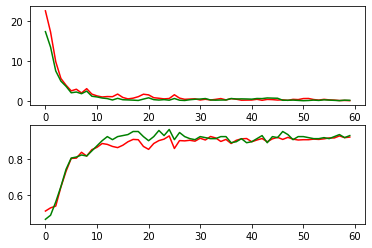

This is No. 2  turn
train_set : test_set = %d : %d 611 175
epoch: 1, train loss: 22.5798, accuracy: 50.90%		valid loss: 17.3975, accuracy: 46.29%
valid sensitivity 87.82,specificity 12.37, precision 51.12
test loss: 20.5435, accuracy: 48.86%
epoch: 2, train loss: 17.2828, accuracy: 52.70%		valid loss: 13.5363, accuracy: 48.57%
valid sensitivity 87.82,specificity 16.05, precision 52.19
test loss: 15.7984, accuracy: 52.27%
epoch: 3, train loss: 9.9208, accuracy: 53.68%		valid loss: 7.6046, accuracy: 56.00%
valid sensitivity 77.88,specificity 28.43, precision 53.17
test loss: 7.5802, accuracy: 55.68%
epoch: 4, train loss: 5.7304, accuracy: 64.32%		valid loss: 5.0618, accuracy: 64.57%
valid sensitivity 88.78,specificity 38.80, precision 60.22
test loss: 4.1492, accuracy: 64.77%
epoch: 5, train loss: 4.0410, accuracy: 73.16%		valid loss: 3.7626, accuracy: 74.29%
valid sensitivity 92.63,specificity 52.84, precision 67.21
test loss: 2.8468, accuracy: 69.32%
epoch: 6, train loss: 2.6377, accur

KeyboardInterrupt: 

In [8]:
  
import sys
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from dgl.data import GINDataset
# from dataloader import GINDataLoader
# from parser import Parser
# from gin import GIN


def train(args, net, trainloader, optimizer, criterion, epoch):
    net.train()

    running_loss = 0
    total_iters = len(trainloader)
    # setup the offset to avoid the overlap with mouse cursor
#     bar = tqdm(range(total_iters), unit='batch', position=2, file=sys.stdout)
    bar = list(range(total_iters))

    for pos, (graphs, labels) in zip(bar, trainloader):
        # batch graphs will be shipped to device in forward part of model
        labels = labels.to(device)
        graphs = graphs.to(device)
        feat = graphs.ndata.pop('w')
        outputs = net(graphs, feat)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # report
#         bar.set_description('epoch-{}'.format(epoch))
#     bar.close()
    # the final batch will be aligned
    running_loss = running_loss / total_iters

    return running_loss


def eval_net(args, net, dataloader, criterion):
    net.eval()

    total = 0
    total_loss = 0
    total_correct = 0
    total_tp = 0
    total_tn = 0
    total_fp = 0
    total_fn = 0

    for data in dataloader:
        graphs, labels = data
        graphs = graphs.to(device)
        labels = labels.to(device)
        feat = graphs.ndata.pop('w')
        total += len(labels)
        outputs = net(graphs, feat)
        _, predicted = torch.max(outputs.data, 1)

        total_correct += (predicted == labels.data).sum().item()
        tn, fp, fn, tp = confusion_matrix(labels.data,predicted, labels=[0,1]).ravel()
        total_tp += tp
        total_tn += tn
        total_fp += fp
        total_fn += fn
        loss = criterion(outputs, labels)
        # crossentropy(reduce=True) for default
        total_loss += loss.item() * len(labels)

    loss, acc = 1.0*total_loss / total, 1.0*total_correct / total
    specificity = total_tn/(total_fp+total_tn)
    sensitivity = total_tp/(total_tp+total_fn)
    precision = total_tp/(total_tp+total_fp)
    net.train()

    return loss, acc, sensitivity, specificity, precision

seed = 0
batch_size = 64
device = torch.device("cpu")
   
num_layers = 4
num_mlp_layers = 5
dim_nfeats = 23
hidden_dim = 32
gclasses = 2
final_dropout = 0.6
learn_eps = False
graph_pooling_type = 'sum'
neighbor_pooling_type = 'sum'
lr = 0.001
epochs = 60

def main(args, fold_idx):

    # set up seeds, args.seed supported
#     torch.manual_seed(seed=args.seed)
#     np.random.seed(seed=args.seed)
    
    torch.manual_seed(seed)
    np.random.seed(seed)

#     is_cuda = not args.disable_cuda and torch.cuda.is_available()

#     if is_cuda:
#         args.device = torch.device("cuda:" + str(args.device))
#         torch.cuda.manual_seed_all(seed=args.seed)
#     else:
#         args.device = torch.device("cpu")

#     dataset = GINDataset(args.dataset, not args.learn_eps)
    
    trainloader, validloader, testloader = GINDataLoader(
        dataset, batch_size=batch_size, device=device,
        seed=seed, shuffle=True,
        split_name='rand', fold_idx=fold_idx).train_valid_loader()
    
    
    

    
    model = GIN(
        num_layers, num_mlp_layers,
        dim_nfeats, hidden_dim, gclasses,
        final_dropout,learn_eps,
        graph_pooling_type, neighbor_pooling_type).to(device)
    
    
    criterion = nn.CrossEntropyLoss()  # defaul reduce is true
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    # it's not cost-effective to hanle the cursor and init 0
    # https://stackoverflow.com/a/23121189
#     tbar = tqdm(range(epochs), unit="epoch", position=3, ncols=0, file=sys.stdout)
#     vbar = tqdm(range(epochs), unit="epoch", position=4, ncols=0, file=sys.stdout)
#     lrbar = tqdm(range(epochs), unit="epoch", position=5, ncols=0, file=sys.stdout)

#     for epoch, _, _ in zip(tbar, vbar, lrbar):
    train_loss_ret, train_acc_ret, train_sens_ret, train_spec_ret, train_prec_ret  = [], [], [], [], []
    val_loss_ret, val_acc_ret, val_sens_ret, val_spec_ret, val_prec_ret = [], [], [], [], []
    test_loss_ret, test_acc_ret, test_sens_ret, test_spec_ret, test_prec_ret = [], [], [], [], []
    for epoch in range(epochs):

        train(args, model, trainloader, optimizer, criterion, epoch)
        scheduler.step()

        train_loss, train_acc, train_sens, train_spec, train_precision= eval_net(
            args, model, trainloader, criterion)
        
        print('epoch: {}, train loss: {:.4f}, accuracy: {:.2f}%'.format(epoch+1, train_loss, 100. * train_acc), end='')
        train_loss_ret.append(train_loss)
        train_acc_ret.append(train_acc)
        train_sens_ret.append(train_sens)
        train_spec_ret.append(train_spec)
        train_prec_ret.append(train_precision)

        valid_loss, valid_acc, valid_sens, valid_spec, valid_precision = eval_net(
            args, model, validloader, criterion)
        print('\t\tvalid loss: {:.4f}, accuracy: {:.2f}%'.format(valid_loss, 100. * valid_acc))
        print('valid sensitivity {:.2f},specificity {:.2f}, precision {:.2f}'.format(100*train_sens, 100*train_spec, 100*train_precision))
        val_loss_ret.append(valid_loss)
        val_acc_ret.append(valid_acc)
        val_sens_ret.append(valid_sens)
        val_spec_ret.append(valid_spec)
        val_prec_ret.append(valid_precision)
        
        test_loss, test_acc, test_sens, test_spec, test_precision = eval_net(
            args, model, testloader, criterion)
        print('test loss: {:.4f}, accuracy: {:.2f}%'.format(test_loss, 100. * test_acc))
#         print('valid sensitivity {:.2f},specificity {:.2f}, precision {:.2f}'.format(100*train_sens, 100*train_spec, 100*train_precision))
        test_loss_ret.append(test_loss)
        test_acc_ret.append(test_acc)
        test_sens_ret.append(test_sens)
        test_spec_ret.append(test_spec)
        test_prec_ret.append(test_precision)
        
    return train_loss_ret, train_acc_ret, train_sens_ret, train_spec_ret, train_prec_ret, val_loss_ret, val_acc_ret, val_sens_ret, val_spec_ret, val_prec_ret, test_loss_ret, test_acc_ret, test_sens_ret, test_spec_ret, test_prec_ret

#save the final result
train_acc_list = []
val_acc_list = []
test_acc_list = []
train_loss_list = []
val_loss_list = []
test_loss_list = []
train_sens_list = []
val_sens_list = []
test_sens_list = []
train_spec_list = []
val_spec_list = []
test_spec_list = []
train_prec_list = []
val_prec_list = []
test_prec_list = []

if __name__ == '__main__':
#     args = Parser(description='GIN').args
#     print('show all arguments configuration...')
#     print(args)
    
    args = None
# for thres_step in range(3):
#     threshold = 0.2+thres_step*0.13

    for idx in range(10):
        threshold=0.8
        seed = 0
        dataset = MyDataset()
        print('This is No. {}  turn'.format(idx+1))
#         train_loss_ret, train_acc_ret, val_loss_ret, val_acc_ret = main(args, idx)
        train_loss_ret, train_acc_ret, train_sens_ret, train_spec_ret, train_prec_ret, val_loss_ret, val_acc_ret, val_sens_ret, val_spec_ret, val_prec_ret, test_loss_ret, test_acc_ret, test_sens_ret, test_spec_ret, test_prec_ret = main(args, idx)
        train_acc_list.append(train_acc_ret[epochs-1])
        val_acc_list.append(val_acc_ret[epochs-1])
        test_acc_list.append(test_acc_ret[epochs-1])
        train_loss_list.append(train_loss_ret[epochs-1])
        val_loss_list.append(val_loss_ret[epochs-1])
        test_loss_list.append(test_loss_ret[epochs-1])
        train_sens_list.append(train_sens_ret[epochs-1])
        val_sens_list.append(val_sens_ret[epochs-1])
        test_sens_list.append(test_sens_ret[epochs-1])
        train_spec_list.append(train_spec_ret[epochs-1])
        val_spec_list.append(val_spec_ret[epochs-1])
        test_spec_list.append(test_spec_ret[epochs-1])
        train_prec_list.append(train_prec_ret[epochs-1])
        val_prec_list.append(val_prec_ret[epochs-1])
        test_prec_list.append(test_prec_ret[epochs-1])
        
        plt.subplot(211)
        plt.plot(list(range(epochs)), train_loss_ret, color='r')
        plt.plot(list(range(epochs)), val_loss_ret, color='g')
        plt.subplot(212)
        plt.plot(list(range(epochs)), train_acc_ret, color='r')
        plt.plot(list(range(epochs)), val_acc_ret, color='g')
        plt.show()

    print('Final result: valid accuracy {:.2f}, valid sensitivity {:.2f}, valid specificity {:.2f}, valid precision {:.2f}'.format(10*sum(val_acc_list), 10*sum(val_sens_list), 10*sum(val_spec_list), 10*sum(val_prec_list)))